# DiploDatos 2021


### Categorización de publicaciones de productos realizadas en Mercado Libre

### 03 - Introducción al Aprendizaje Automático

#### Condiciones generales que aplican a todos los prácticos:
   - Las notebooks tienen que ser 100% reproducibles, es decir al ejecutar las celdas tal cuál como se entrega la notebook se deben obtener los mismos resultados sin errores.
   - Código legible, haciendo buen uso de las celdas de la notebook y en lo posible seguir estándares de código para *Python* (https://www.python.org/dev/peps/pep-0008/).
   - Utilizar celdas tipo *Markdown* para ir guiando el análisis.
   - Limpiar el output de las celdas antes de entregar el notebook (ir a `Kernel` --> `Restart Kernel and Clear All Ouputs`).
   - Incluir conclusiones del análisis que se hizo en la sección "Conclusiones". Tratar de aportar valor en esta sección, ser creativo.

## 1. Consignas

**Opcional**

Entregar la solución en scripts de *Python*. Se lo puede separar al proyecto en `data.py`, `models.py`, `metrics.py`, `train.py`, etc.

#### Sección 0: División en *train set* y *test set*

- Dividir en entrenamiento (80%) y test (20%).

#### Sección 1: Definición de *embedding layer*

Tomamos lo generado en el TP anterior. Por lo tanto, partir de lo ya hecho para tener:

- *Sequences*

- *Labels*

- Capa de *Embedding*

(Tener en cuenta que la *tokenización* se hace por separado en los conjuntos de entrenamiento y test, para evitar *leakage* de datos).

#### Sección 2: División en *train set* y *validation set*

- Dividir al conjunto de entrenamiento en entrenamiento y validación utilizando el método de *Stratified K-Folds*. [Documentación](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold).

#### Sección 3: Entrenamiento de un modelo

- Realizar el entrenamiento de un modelo.

- Se aconseja comenzar por una red neuronal *feed forward*, y/o capas del tipo *LSTM*.

- La primera capa de la red será la *embedding_layer* que ya hayan definido y la última capa será una capa densa con `cantidad de neuronas == cantidad de clases` y función de activación *softmax*.

- Entrenar modelos que utilicen tanto los embeddings pre-entrenados como los customs.

- Experimentar utilizando *dropout* y *batch normalization*.

- Utilizar *checkpoints* para guardar el modelo.

- Utilizar como *loss* la *sparse_categorical_crossentropy*, y se recomienda utilizar *Adam* como *optimizer*.

#### Sección 4: Evaluación del modelo

- Graficar curvas de *loss* y *accuracy* para entrenamiento y validación. Se puede hacer utilizando el *model history* de *Keras*. [Documentación](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History).

- Utilizar *balance accuracy* para medir la performance del modelo en test. [Documentación](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html).

- Diferenciar el *score* según *label_quality*. Es decir, calcular el puntaje para el conjunto de test separando según *reliable* y *unreliable*.

#### Sección 5: Análisis de resultados

- Realizar análisis de que modelo performó mejor, generar un `.csv` con los resultados en test de cada modelo.

#### Sección 6: Exportado de predicciones

- Generar un *dataframe* con las predicciones del conjunto de test del mejor modelo, y exportarlo a un `.csv`.

## 2. Código y análisis

Instalaciones necesarias

In [1]:
!pip install Unidecode

Importaciones necesarias

In [2]:
import pandas as pd
import numpy as np

Lectura de dataset reducido

In [3]:
df_dataset = pd.read_csv('DataSet/dataset.csv')

Estudiamos el dataset brevemente antes de comenzar a operar sobre el mismo.

In [4]:
df_dataset.describe()

,title,label_quality,language,category
count,646760,646760,646760,646760
unique,646019,2,2,20
top,Shitzu,unreliable,portuguese,PANTS
freq,2,551878,328992,35973


In [5]:
classes = np.sort(df_dataset.category.unique())

print(f'Dimensiones: {df_dataset.shape}')
print('----------')
print(f'Variables: {list(df_dataset.columns)}')
print('----------')
print(f'Categorías: {list(classes)}')

Dimensiones: (646760, 4)
----------
Variables: ['title', 'label_quality', 'language', 'category']
----------
Categorías: ['BABY_CAR_SEATS', 'BABY_STROLLERS', 'COFFEE_MAKERS', 'ELECTRIC_DRILLS', 'HAIR_CLIPPERS', 'KITCHEN_SINKS', 'MATTRESSES', 'MEMORY_CARDS', 'MOTORCYCLE_JACKETS', 'MUSICAL_KEYBOARDS', 'PANTS', 'PUREBRED_DOGS', 'RANGES', 'REFRIGERATORS', 'ROLLER_SKATES', 'SEWING_MACHINES', 'SHORTS', 'SUITCASES', 'WALL_CLOCKS', 'WINES']


**Sección 0**

In [6]:
from scripts.utils import cleaning

df_dataset['clean_title'] = df_dataset.title.apply(cleaning)

In [7]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_dataset, train_size=0.8, test_size=0.2, random_state=123)

print(f'Dimensiones Entrenamiento: {df_train.shape}')
print(f'Dimensiones Evaluación: {df_test.shape}')

Dimensiones Entrenamiento: (517408, 5)
Dimensiones Evaluación: (129352, 5)


In [8]:
# Datos de Entrenamiento
X_train = df_train.clean_title.values
y_train = df_train.category.values
# Datos de Test
X_test = df_test.clean_title.values
y_test = df_test.category.values

**Sección 1**

In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

word_tokenizer = Tokenizer()
# Aprendemos el Tokenizer en base a los datos de entrenamiento.
word_tokenizer.fit_on_texts(X_train)
# Longitud del Vocabulario en base a los datos de entrenamiento.
vocab_length = len(word_tokenizer.word_index) + 1

embedded_sentences_train = word_tokenizer.texts_to_sequences(X_train)
embedded_sentences_test = word_tokenizer.texts_to_sequences(X_test)

padded_sentences_train = pad_sequences(embedded_sentences_train, padding='post')
# Longitud de Sentencias en base a los datos de entrenamiento.
ammount_sentences, sentences_length = padded_sentences_train.shape

padded_sentences_test = pad_sequences(embedded_sentences_test, padding='post', maxlen=sentences_length)

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(classes)

encoded_labels_train = le.transform(y_train)
encoded_labels_test = le.transform(y_test)

In [11]:
from keras.layers.embeddings import Embedding

dense_vector_size = 30
embedding_layer = Embedding(vocab_length, dense_vector_size, input_length=sentences_length)

**Observación**

Solo trabajaremos con *custom embeddings* por dificultades encontradas al adaptar el modelo a los *word vectors* preentrenados de **fastText**.
Una tarea que quedará pendiente, será replantear el uso de esta herramienta.

**Sección 2**

In [12]:
from scripts.models import NN_Baseline_Model, NN_Dropout_Model, NN_Batch_Model

m1 = NN_Baseline_Model(embedding_layer, classes)
m2 = NN_Dropout_Model(embedding_layer, classes)
m3 = NN_Batch_Model(embedding_layer, classes)

models = {m1.name: m1.model, m2.name: m2.model, m3.name: m3.model}
weights = {m1.name: m1.filepath, m2.name: m2.filepath, m3.name: m3.filepath}

Se trabajará con tres modelos diferentes.

* `Baseline` Consiste simplemente de capas densas, con función de activación sigmoide.
* `Dropout` Consiste de capas densas, con función de activación *relu*, y neuronas con *dropout*.
* `Batch` Consiste de capas densas, con función de activación sigmoide, y normalización por *batch*.

In [13]:
from sklearn.model_selection import StratifiedKFold

splits = 3
kf = StratifiedKFold(splits)

In [14]:
from scripts.train import cross_validation

for name, model in models.items():
  mean_loss, mean_accuracy = cross_validation(model,
                                              weights[name],
                                              kf.split(X_train, y_train),
                                              padded_sentences_train,
                                              encoded_labels_train)
  
  print(f'{name}:')
  print(f'\tMean Loss {mean_loss}')
  print(f'\tMean Accuracy {mean_accuracy}')

10780/10780 [==============================] - 324s 30ms/step - loss: 1.1811 - accuracy: 0.6431
Neural_Network_Baseline:
	Mean Loss 0.11803272366523743
	Mean Accuracy 0.9694554209709167
10780/10780 [==============================] - 339s 31ms/step - loss: 0.1269 - accuracy: 0.9665
Neural_Network_Dropout:
	Mean Loss 0.057294391095638275
	Mean Accuracy 0.9859608014424642
10780/10780 [==============================] - 354s 33ms/step - loss: 0.1010 - accuracy: 0.9759
Neural_Network_Batch:
	Mean Loss 0.06921106576919556
	Mean Accuracy 0.9827099839846293


Aplicando **validación cruzada** para analizar que tan robusto es cada modelo frente a variaciones del conjunto de entrenamiento, observamos que `Dropout` consigue el mejor rendimiento (al analizar la *accuracy* promedio).

**Sección 3**

In [15]:
from scripts.train import train

training = {}
for name, model in models.items():
  print(f'{name}:')
  history = train(name, model, padded_sentences_train, encoded_labels_train)
  training[name] = history

Neural_Network_Baseline:
Epoch 1/5
12936/12936 [==============================] - 383s 30ms/step - loss: 0.7880 - accuracy: 0.7673 - val_loss: 0.1243 - val_accuracy: 0.9683
Epoch 2/5
12936/12936 [==============================] - 382s 30ms/step - loss: 0.0945 - accuracy: 0.9753 - val_loss: 0.0923 - val_accuracy: 0.9759
Epoch 3/5
12936/12936 [==============================] - 383s 30ms/step - loss: 0.0640 - accuracy: 0.9831 - val_loss: 0.0799 - val_accuracy: 0.9803
Epoch 4/5
12936/12936 [==============================] - 386s 30ms/step - loss: 0.0491 - accuracy: 0.9868 - val_loss: 0.0749 - val_accuracy: 0.9818
Epoch 5/5
12936/12936 [==============================] - 386s 30ms/step - loss: 0.0406 - accuracy: 0.9890 - val_loss: 0.0789 - val_accuracy: 0.9816
Neural_Network_Dropout:
Epoch 1/5
12936/12936 [==============================] - 410s 32ms/step - loss: 0.0622 - accuracy: 0.9841 - val_loss: 0.0610 - val_accuracy: 0.9847
Epoch 2/5
12936/12936 [==============================] - 414s 3

En esta instancia, realizamos el entrenamiento completo para cada red neuronal.

**Sección 4**

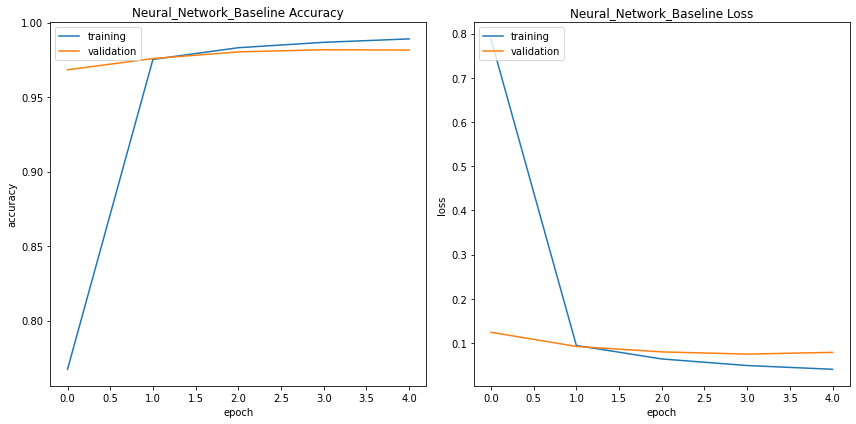

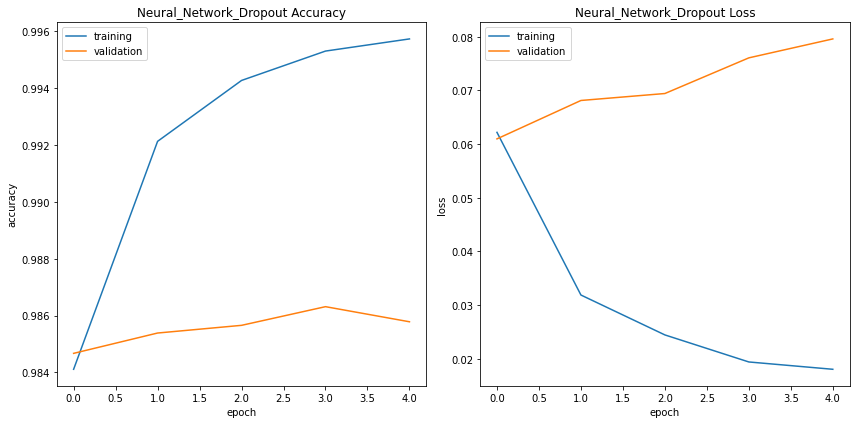

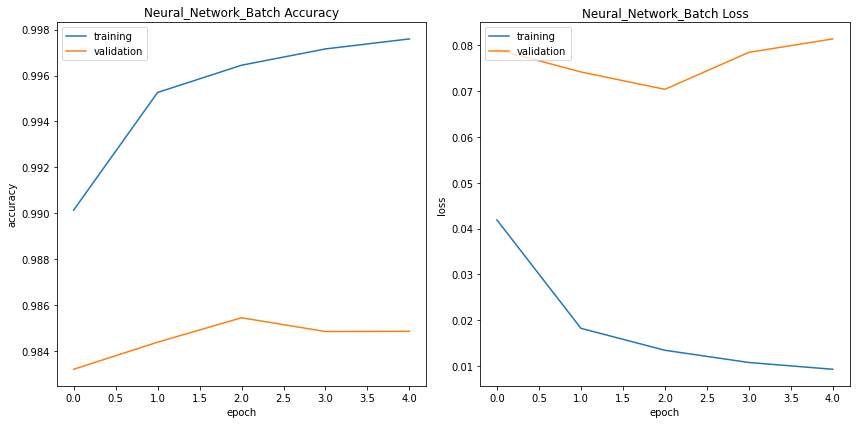

In [16]:
from scripts.metrics import plot_accuracy_loss

for name, train in training.items():
  plot_accuracy_loss(train, name)

Se observan problemas de *overfitting* en el entrenamiento. Se podría decir que es algo esperable al considerar la cantidad de parámetros que posee cada una de las redes neuronales definidas.

De todas maneras, el rendimiento de todos los modelos parece ser excelente.

In [17]:
from scripts.metrics import show_balanced_accuracy

for name, model in models.items():
  show_balanced_accuracy(name, model, padded_sentences_test, encoded_labels_test, df_test)

Neural_Network_Baseline
Balanced Accuracy (General): 0.9372363660724142
Balanced Accuracy (Reliable): 0.9565968970685267
Balanced Accuracy (Unreliable): 0.9337234133501227
Neural_Network_Dropout
Balanced Accuracy (General): 0.7072049075102135
Balanced Accuracy (Reliable): 0.7339257756246357
Balanced Accuracy (Unreliable): 0.7034720947444197
Neural_Network_Batch
Balanced Accuracy (General): 0.9848358755275617
Balanced Accuracy (Reliable): 0.9916690947098663
Balanced Accuracy (Unreliable): 0.9835940873738874


Según la **balanced accuracy**, nuestro mejor modelo parece ser `Batch`.

Notar que todas las redes neuronales obtuvieron mejores resultados en los conjuntos de datos con etiquetas *confiables*.

**Sección 5**

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(encoded_labels_test, predictions, target_names=classes))

                    precision    recall  f1-score   support

    BABY_CAR_SEATS       0.98      0.97      0.98      6709
    BABY_STROLLERS       0.97      0.98      0.97      6219
     COFFEE_MAKERS       0.99      0.99      0.99      6968
   ELECTRIC_DRILLS       0.99      0.99      0.99      6304
     HAIR_CLIPPERS       0.98      0.99      0.98      6421
     KITCHEN_SINKS       1.00      0.99      0.99      6242
        MATTRESSES       0.99      0.99      0.99      6546
      MEMORY_CARDS       0.99      0.98      0.99      6139
MOTORCYCLE_JACKETS       0.99      0.99      0.99      6500
 MUSICAL_KEYBOARDS       0.99      0.99      0.99      6671
             PANTS       0.97      0.98      0.98      7225
     PUREBRED_DOGS       0.97      0.99      0.98      6606
            RANGES       0.99      0.99      0.99      6553
     REFRIGERATORS       0.99      0.99      0.99      6469
     ROLLER_SKATES       1.00      0.99      0.99      6329
   SEWING_MACHINES       0.98      0.98

In [ ]:
# TO DO

**Sección 6**

In [ ]:
test_title = df_test.title
test_prediction = le.inverse_transform(predictions)

submission = pd.DataFrame(list(zip(test_title, test_prediction)), columns=['title', 'category'])
submission.to_csv('DataSet/dataset_submission.csv', header=True, index=False)

## 3. Conclusiones

In [ ]:
# TO DO